This lesson was adapted from the end of [lesson 3](https://course.fast.ai/videos/?lesson=3) and beginning of [lesson 4](https://course.fast.ai/videos/?lesson=4) of the latest fast.ai Practical Deep Learning for Coders course.  We will cover all the material you need here in this notebook, so no need to have taken the Deep Learning course.  Even if you have taken the DL class, we will go slower and get into more detail here!

# Language Modeling & Sentiment Analysis of IMDB movie reviews

We will be looking at IMDB movie reviews.  We want to determine if a review is negative or positive, based on the text.  In order to do this, we will be using **transfer learning**.

Transfer learning has been widely used with great success in computer vision for several years, but only in the last year or so has it been successfully applied to NLP (beginning with ULMFit, which we will use here, which was built upon by BERT and GPT-2).

As Sebastian Ruder wrote in [The Gradient](https://thegradient.pub/) last summer, [NLP's ImageNet moment has arrived](https://thegradient.pub/nlp-imagenet/).

## Language Models

Language modeling can be a fun creative form. Research scientist [Janelle Shane blogs](https://aiweirdness.com/) & [tweets](https://twitter.com/JanelleCShane) about her creative AI explorations, which often involve text.  For instance, see her:

- [Why did the neural network cross the road?](https://aiweirdness.com/post/174691534037/why-did-the-neural-network-cross-the-road)
- [Try these neural network-generated recipes at your own risk.](https://aiweirdness.com/post/163878889437/try-these-neural-network-generated-recipes-at-your)
- [D&D character bios - now making slightly more sense](https://aiweirdness.com/post/183471928977/dd-character-bios-now-making-slightly-more)

## Using a GPU

You will need to have the fastai library installed for this lesson, and you will want to use a GPU to train your neural net.  If you don't have a GPU you can use in your computer (currently, only Nvidia GPUs are fully supported by the main deep learning libraries), no worries!  There are a number of cloud options you can consider:

[GPU Cloud Options](https://course.fast.ai/#using-a-gpu)

**Reminder: If you are using a cloud GPU, always be sure to shut it down when you are done!!! Otherwise, you could end up with an expensive bill!**

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai import datasets
from fastai.text import *

In [103]:
# import fastai.utils.collect_env

# fastai.utils.collect_env.show_install()

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [4]:
# bs=48
# bs=24
bs=48

In [5]:
torch.cuda.set_device(0)

## Preparing the data (on a sample)

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [6]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/davidhsv/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [7]:
imdb_sample_TextDB = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [8]:
imdb_sample_TextDB.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [9]:
imdb_sample_TextDB.train_ds[0][0]

Text xxbos xxmaj based on xxmaj tom xxmaj wolfe 's satirical novel that was praised by all ( i have not read it yet ) xxmaj tom xxmaj hanks stars as a wall xxunk who accidentally kills a black boy while lost in a bad part of xxup nyc xxmaj willis stars as the reporter who starts xxmaj hanks on his xxunk spiral .. xxmaj the characters are very thin and there seems to be no empathy for anyone in this movie and for a comedy or a satire there are nt a lot of laughs either .. xxmaj xxunk xxmaj griffith had her breasts done during filming so a fun thing to do is to see if her boobs change size during different parts of the film .. xxmaj this will keep your mind off other things like the lack of script or humor .. xxmaj on a scale of one to ten .. 3

But the underlying data is all numbers

In [10]:
imdb_sample_TextDB.train_ds[0][0].data[:10]

array([   2,    5,  488,   36,    5,  740,    5, 4692,   23, 6090])

### Alternative apporach: with the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [11]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Now let's grab the full dataset for what follows.

In [12]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/davidhsv/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/unsup'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/test'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/README'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/models'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/train')]

In [13]:
(path/'train').ls()

[PosixPath('/home/davidhsv/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/train/pos'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/train/neg')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

### More about WikiText-103

We will be using the [WikiText-103](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) dataset created by [Stephen Merity](https://smerity.com/) to pre-train a language model.

To quote [Stephen's post](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/):

*The WikiText language modeling dataset is a collection of over 100 million tokens extracted from the set of verified Good and Featured articles on Wikipedia. The dataset is available under the Creative Commons Attribution-ShareAlike License.*

*Compared to the preprocessed version of Penn Treebank (PTB), WikiText-2 is over 2 times larger and WikiText-103 is over 110 times larger. The WikiText dataset also features a far larger vocabulary and retains the original case, punctuation and numbers - all of which are removed in PTB. As it is composed of full articles, the dataset is well suited for models that can take advantage of long term dependencies.*

### Creating the TextLMDataBunch

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [14]:
path.ls()

[PosixPath('/home/davidhsv/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/unsup'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/test'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/lm_databunch'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/README'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/models'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/davidhsv/.fastai/data/imdb/train')]

In [15]:
imdb_sample_TextDB = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1, seed=42)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs, num_workers=1))

In [16]:
len(imdb_sample_TextDB.vocab.itos),len(imdb_sample_TextDB.train_ds)

(60000, 90000)

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [17]:
imdb_sample_TextDB.show_batch()

idx,text
0,"xxmaj like the film xxup runaway xxup bride , xxmaj ginger plays a woman who uses men -- leaving them again and again at the alter . xxmaj all this is intended to be kooky , but i found myself hating her character from the start due to her selfishness and whiny voice . i honestly would have loved it if one of her many xxunk had just slugged her"
1,"special , this one is n't too far off . \n \n xxmaj why ? xxmaj one word : football . \n \n xxmaj this is the one special where xxmaj charlie xxmaj brown successfully kicks the football ... and taunts / teases xxmaj lucy as he does it . \n \n xxmaj yeah , it 's always interesting to see how ol' xxmaj chuck handles it"
2,"smallest change in acting . \n \n xxmaj simple plot , overwhelming acting , financial flop , just a terrific film . \n \n xxmaj thumbs up and 10 points xxbos xxmaj this movie is nervous and uncomfortably over - acted . a story of hatred like such is not at all surprising nowadays . xxmaj but the director seems too restless to do a good film ."
3,singing it in my head when i was doing boring work or just walking around . xxmaj then last night at 3:30 or so i decided to head to bed and i flipped through the xxup tv channels out of habit and found this movie was on again . xxmaj of course i stayed up until 5 watching it . if anyone has a chance to watch this film i
4,"are off in the country and dubbed horribly into xxmaj english . xxmaj but only sometimes . xxmaj randomly , some of the movie is in xxmaj french , which i guess is to give the impression some people really are xxmaj french and some are n't ? xxmaj or not . i have no idea , but it does n't matter . xxmaj by the time you hear xxmaj"


Let's save our databunch for next time:

In [18]:
imdb_sample_TextDB.save('lm_databunch')

### Loading saved data, and creating the language model

In the future we can load the data:

In [19]:
imdb_sample_TextDB = load_data(path, 'lm_databunch', bs=bs)

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [20]:
learn_lm = language_model_learner(imdb_sample_TextDB, AWD_LSTM, drop_mult=0.3)

In [21]:
wiki_itos = pickle.load(open(Config().model_path()/'wt103-fwd/itos_wt103.pkl', 'rb'))

In [22]:
wiki_itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [23]:
vocab = imdb_sample_TextDB.vocab

In [24]:
vocab.stoi["stingray"]

41465

In [25]:
vocab.itos[vocab.stoi["stingray"]]

'stingray'

In [26]:
vocab.itos[vocab.stoi["mobula"]]

'xxunk'

In [27]:
awd = learn_lm.model[0]

In [28]:
from scipy.spatial.distance import cosine as dist

In [29]:
enc = learn_lm.model[0].encoder

In [30]:
enc.weight.size()

torch.Size([60000, 400])

### Difference in vocabulary between IMDB and Wikipedia

We are going to load wiki_itos, which can be downloaded along with wikitext-103.  We will compare the vocabulary from wikitext with the vocabulary in IMDB.  It is to be expected that the two sets have some different vocabulary words, and that is no problem for transfer learning!

In [31]:
len(wiki_itos)

60000

In [32]:
len(vocab.itos)

60000

In [33]:
i, unks = 0, []
while len(unks) < 50:
    if imdb_sample_TextDB.vocab.itos[i] not in wiki_itos: unks.append((i,imdb_sample_TextDB.vocab.itos[i]))
    i += 1

In [34]:
wiki_words = set(wiki_itos)

In [35]:
imdb_words = set(vocab.itos)

In [36]:
wiki_not_imbdb = wiki_words.difference(imdb_words)

In [37]:
imdb_not_wiki = imdb_words.difference(wiki_words)

In [38]:
wiki_not_imdb_list = []

for i in range(100):
    word = wiki_not_imbdb.pop()
    wiki_not_imdb_list.append(word)
    wiki_not_imbdb.add(word)

In [39]:
wiki_not_imdb_list[:15]

['betances',
 'ohl',
 'moxon',
 '2,250',
 'v-1',
 'tsarina',
 'sheerness',
 'sedin',
 'rosaline',
 'talud',
 'cuisines',
 'awiil',
 'solubility',
 'gheorghe',
 'korhal']

In [40]:
imdb_not_wiki_list = []

for i in range(100):
    word = imdb_not_wiki.pop()
    imdb_not_wiki_list.append(word)
    imdb_not_wiki.add(word)

In [41]:
imdb_not_wiki_list[:15]

['foulkrod',
 'untroubled',
 'deighton',
 'tylo',
 'overachieving',
 'trimalcione',
 '8-',
 'outhwaite',
 'niller',
 'charachters',
 'herzlinger',
 'perms',
 'mayu',
 'squinty',
 'carne']

All words that appear in the IMDB vocab, but not the wikitext-103 vocab, will be initialized to the same random vector in a model.  As the model trains, we will learn these weights.

In [42]:
vocab.stoi["modernisation"]

0

In [43]:
"modernisation" in wiki_words

True

In [44]:
vocab.stoi["30-something"]

28224

In [45]:
"30-something" in wiki_words, "30-something" in imdb_words

(False, True)

In [46]:
vocab.stoi["linklater"]

17078

In [47]:
"linklater" in wiki_words, "linklater" in imdb_words

(False, True)

In [48]:
"house" in wiki_words, "house" in imdb_words

(True, True)

In [49]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], 
            enc.weight[vocab.stoi["linklater"], :])

True

In [50]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], 
            enc.weight[vocab.stoi["house"], :])

False

In [51]:
new_word_vec = enc.weight[vocab.stoi["linklater"], :]

### Generating fake movie reviews (using wiki-text model)

In [52]:
TEXT = "The color of the sky is"
N_WORDS = 40
N_SENTENCES = 2

In [53]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

The color of the sky is yellow , the beak is red , and the green is yellow . The red and blue colours of the red sky are described in the Blacker Welch Art . The landscapes of the
The color of the sky is not clear , but the color of the sky and the sky are still different . Some of the Sun may be red or blue . He is depicted as a blind , blinded , calm ,


In [54]:
TEXT = "I hated this movie"
N_WORDS = 30
N_SENTENCES = 2

In [55]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie for a few years and it was one of the few films that not only had its own feld - based cast , but the movie 's early sequels to
I hated this movie by the Royal Geographical Society and was a university at Oxford University . The school was a " museum " for its young students


In [56]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie , and Kevin Moore wrote in the Press Box that he was " very excited " to write a film adaptation . However , the
I hated this movie by an actor like Jane Austen . As Peter Pan wrote to The Illustrated London News , " It was


In [57]:
doc(LanguageLearner.predict)

Lowering `temperature` will make the texts less randomized.

In [58]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie by John Lennon , and he said he was " a fan of the Beatles " . He said that he was " a fan of
I hated this movie by John Lennon , and he said , " It 's a great movie . It 's a great film . It 's a great


In [59]:
doc(LanguageLearner.predict)

In [60]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.10) for _ in range(N_SENTENCES)))

I hated this movie by John Lennon and Paul mccartney , and the film The Lord of the Rings : The Return of the King
I hated this movie by John Lennon , and it was a reference to the American film The Lord of the Rings . The film was also


### Training the model

Now, we want to choose a good learning rate.

In [61]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


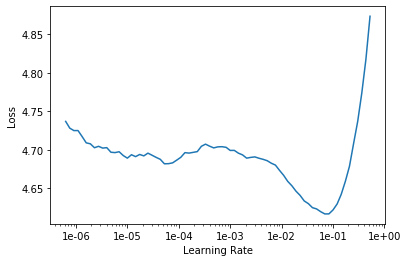

In [62]:
learn_lm.recorder.plot(skip_end=15)

In [63]:
lr = 1e-3
lr *= bs/48

In [64]:
learn_lm.to_fp16();

In [65]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

Since this is relatively slow to train, we will save our weights:

In [66]:
learn_lm.save('fit_1')

In [67]:
learn_lm.load('fit_1');

To complete the fine-tuning, we can then unfreeze and launch a new training.

In [68]:
learn_lm.unfreeze()

In [69]:
learn_lm.fit_one_cycle(10, lr, moms=(0.8,0.7))

In [70]:
learn_lm.save('fine_tuned')

We have to save not just the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [71]:
learn_lm.save_encoder('fine_tuned_enc')

### Loading our saved weights

In [72]:
learn_lm.load('fine_tuned');

Now that we've trained our model, different representations have been learned for the words that were in IMDB but not wiki (remember that at the beginning we had initialized them all to the same thing):

In [73]:
enc = learn_lm.model[0].encoder

In [74]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], 
            enc.weight[vocab.stoi["linklater"], :])

False

In [75]:
np.allclose(enc.weight[vocab.stoi["30-something"], :], new_word_vec)

False

### More generated movie reviews

How good is our model? Well let's try to see what it predicts after a few given words.

In [101]:
TEXT = "i liked this movie because"
N_WORDS = 40
N_SENTENCES = 2

print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

i liked this movie because it has a very good storyline , a good story line , and a good cast . i really enjoyed it , and it was very well done . There was n't a lot of action , and you
i liked this movie because it reminded me of the Kate & Charlotte movies that i think i have seen in a lot of times . The movie had an emotional following that made it all the more beautiful . 
 
 


In [78]:
TEXT = "This movie was"
N_WORDS = 30
N_SENTENCES = 2

In [79]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

This movie was so bad i had to turn it off . The story is just a joke , the ending is so stupid and all the characters are stupid .
This movie was awesome . It was so smart and so unique . It was funny , funny and sad . i am not a big fan of useless movies but


In [80]:
TEXT = "I hated this movie"
N_WORDS = 40
N_SENTENCES = 2

In [81]:
print("\n".join(learn_lm.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hated this movie . The plot is lame , the acting is atrocious , the direction is horrible , the dialogue is horrible , they have absolutely no idea what to do with their lives , and the direction is awful .
I hated this movie . i had no idea how the movie was going to end . The acting was atrocious . The characters were gay . i wanted to like this movie . The storyline was ridiculous . The


### Risks of language models

We will talk about ethical concerns raised by very accurate language models in lesson 7, but here are a few brief notes:

In reference to [OpenAI's GPT-2](https://www.theverge.com/2019/2/14/18224704/ai-machine-learning-language-models-read-write-openai-gpt2): Jeremy Howard said, *I’ve been trying to warn people about this for a while. We have the technology to totally fill Twitter, email, and the web up with reasonable-sounding, context-appropriate prose, which would drown out all other speech and be impossible to filter.*

For a small example, consider when completely incorrect (but reasonable sounding) ML generated answers were [posted to StackOverflow](https://meta.stackoverflow.com/questions/384596/completely-incorrect-machine-learning-generated-answers?stw=2):

<img src="images/robot-overflow.png" alt="Roboflow" style="width: 80%"/>

<img src="images/husain-tweet.png" alt="Roboflow" style="width: 60%"/>

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [82]:
bs=48

In [83]:
data_clas = (TextList.from_folder(path, vocab=imdb_sample_TextDB.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs, num_workers=1))

In [84]:
data_clas.save('imdb_textlist_class')

In [85]:
data_clas = load_data(path, 'imdb_textlist_class', bs=bs, num_workers=1)

In [86]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n \n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , steaming bowl of oatmeal . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj",neg
"xxbos xxmaj jim xxmaj carrey is back to much the same role that he played in xxmaj the xxmaj mask , a timid guy who is trying to get ahead in the world but who seems to be plagued with bad luck . xxmaj even when he tries to help a homeless guy from being harassed by a bunch of hoodlums ( and of course they have to be xxmaj",pos
"xxbos xxmaj the premise of this movie has been tickling my imagination for quite some time now . xxmaj we 've all heard or read about it in some kind of con - text . xxmaj what would you do if you were all alone in the world ? xxmaj what would you do if the entire world suddenly disappeared in front of your eyes ? xxmaj in fact ,",pos
"xxbos xxmaj the majority of xxmaj stephen xxmaj king 's short stories are little gems , with original ideas that do n't take a long time to develop ; basically lean and mean -- he sets them up quickly in a scarce number of pages , you read 'em , and you 're finished before you know you 've begun . xxmaj they 're like the equivalent of a carton",neg


We can then create a model to classify those reviews and load the encoder we saved before.

In [87]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3) #.to_fp16()
learn_c.load_encoder('fine_tuned_enc')
learn_c.freeze()

In [88]:
learn_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


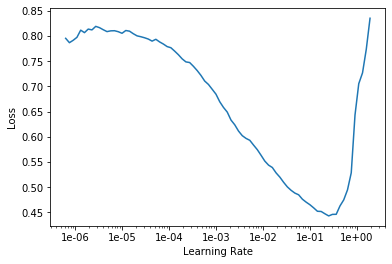

In [89]:
learn_c.recorder.plot()

In [90]:
learn_c.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

In [91]:
learn_c.save('first')

In [92]:
learn_c.load('first');

In [93]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

In [94]:
learn_c.save('2nd')

In [97]:

torch.cuda.empty_cache()

In [95]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

RuntimeError: CUDA out of memory. Tried to allocate 294.00 MiB (GPU 0; 7.93 GiB total capacity; 6.59 GiB already allocated; 205.38 MiB free; 330.60 MiB cached)

In [ ]:
learn_c.save('3rd')

In [ ]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

The state of the art for this dataset in 2017 was 94.1%.

In [ ]:
learn_c.save('clas')

In [ ]:
learn_c.predict("I really loved that movie, it was awesome!")

In [ ]:
learn_c.predict("I didn't really love that movie, and I didn't think it was awesome.")

## Language Model Zoo

fast.ai alumni have applied ULMFit to dozens of different languages, and have beat the SOTA in Thai, Polish, German, Indonesian, Hindi, & Malay.

They share tips and best practices in [this forum thread](https://forums.fast.ai/t/language-model-zoo-gorilla/14623) in case you are interested in getting involved!

<img src="images/language_model_zoo.png" alt="language model zoo" style="width: 80%"/>